# Assignment 2: Ear detection - testing of different detectors

In [1]:
# Import libraries
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()

In [3]:
# Read the cascade files
cascades = [cv2.CascadeClassifier("haarcascade_ear.xml"),
            cv2.CascadeClassifier("haarcascade_ear_2.xml"),  
            cv2.CascadeClassifier("lbp.xml")]

cascadeFace = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [4]:
# Set the paths
test_folder_path = cwd + '\\test\\'
test_annot_path = cwd + '\\testannot\\'
test_annot_rect = cwd + '\\testannot_rect\\'
results_folder_path = cwd + '\\results\\'
results_ear = cwd + '\\results_ear\\'
results_face = cwd + '\\results_face\\'

In [8]:
# Function for ear or face detection depending on the parameter 'part_to_detect'
def detector(img, part_to_detect):
    if part_to_detect == 'ear':
        detectionList = cascadeEar.detectMultiScale(img, scale_factor, min_neighbour, minSize=(5, 5))
        return detectionList
    else:
        detectionList = cascadeFace.detectMultiScale(img, scale_factor, min_neighbour, minSize=(5, 5))
        return detectionList

# Function for drawing a mask on the detected ear region
def vizualization(img, detectionList, results_folder_path, fname):
    for x, y, w, h in detectionList:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), -1) # the rectangle is white and filled
    cv2.imwrite(results_folder_path + fname, img)
    
# Function to draw a barplot showing the Intersection over Union scores of different cascades
def draw_barplot(iou_scores_df):
    fig, ax = plt.subplots(3, 1, figsize=(15, 30))
    iou_scores_df['haar_cascade_ear_1'].plot.bar(x=np.arange(9), ax=ax[0], rot=0)
    iou_scores_df['haar_cascade_ear_2'].plot.bar(x=np.arange(9), ax=ax[1], rot=0)
    iou_scores_df['LBP'].plot.bar(x=np.arange(9), ax=ax[2], rot=0)
    titles = ['First Haar cascade for ear detection',
              'Second Haar cascade for ear detection',
              'LBP detector']
    x_labels = [('1.3, 3'), ('1.3, 5'), ('1.3, 10'), ('1.1, 3'), ('1.1, 5'), ('1.1, 10'), ('1.05, 3'), ('1.05, 5'), ('1.05, 10')]
    for (i, axis) in enumerate(ax):
        ax[i].set_title(titles[i], fontsize=20)
        ax[i].set_xticks(np.arange(9))
        ax[i].set_xticklabels(x_labels, fontsize=15)
        ax[i].set_xlabel('Parameters', fontsize=20)
        for label in ax[i].get_yticklabels():
            label.set_fontsize(15)
        ax[i].set_ylabel('Intersection over Union score', fontsize=20);

In [6]:
# Generating the names of the pictures in the folder 'test' in 'AWEForSegmentation'
fnames = range(1, 251)
fname_strings = []
for fname in fnames:
    if len(str(fname)) == 1:
        fname_strings.append('000' + str(fname) + '.png')
    if len(str(fname)) == 2:
        fname_strings.append('00' + str(fname) + '.png')
    if len(str(fname)) == 3:
        fname_strings.append('0' + str(fname) + '.png')

## Testing the Haar cascades and the LBP detector

In [14]:
# Test for selected values of the parameters: scaleFactor and minNeighbours; parameter minSize is fixed in the definition of
# the function 'detector' 
scale_factors = [1.3, 1.1, 1.05]
min_neighbours = [3, 5, 10]

# Creation of the DataFrame 'iou_scores_df' in which we are going to store our Intersection over Union scores for the different 
# cascades tested with different sets of parameters
iou_scores_df = pd.DataFrame()
params = [[1.3, 1.3, 1.3, 1.1, 1.1, 1.1, 1.05, 1.05, 1.05], [3, 5, 10, 3, 5, 10, 3, 5, 10]]
index = pd.MultiIndex.from_arrays(params, names=('Scale factors', 'Min. neighbours'))

# 'For' loop for detection and evaluation
for cascadeEar in cascades:
    iou_scores = []
    
    for scale_factor in scale_factors:
        for min_neighbour in min_neighbours:
            min_neigh_scores = []
            
            for fname in fname_strings:
                # Ear detection
                img = cv2.imread(test_folder_path + fname)
                img_annot = cv2.imread(test_annot_path + fname)
                img_annot = np.zeros(img_annot.shape)
                detectionList = detector(img, 'ear')
                vizualization(img_annot, detectionList, results_folder_path, fname)

                # Evaluation of detector
                tmp_annot_im = cv2.imread(test_annot_rect + fname)
                ind_for_white = tmp_annot_im >= 128
                tmp_annot_im[ind_for_white] = 255
                ind_for_black = tmp_annot_im < 128
                tmp_annot_im[ind_for_black] = 0
                tmp_results_im = cv2.imread(results_folder_path + fname)
                intersection = np.logical_and(tmp_annot_im, tmp_results_im)
                union = np.logical_or(tmp_annot_im, tmp_results_im)
                tmp_score = np.sum(intersection) / np.sum(union)
                min_neigh_scores.append(tmp_score)
                
            iou_scores.append(np.round(np.average(min_neigh_scores), 3))
    
    # Adding the results for a particular cascade to 'iou_scores_df'
    tmp_df = pd.DataFrame(iou_scores, index=index)
    iou_scores_df = pd.concat([iou_scores_df, tmp_df], axis=1)

iou_scores_df.columns = ['haar_cascade_ear_1', 'haar_cascade_ear_2', 'LBP']
iou_scores_df

haar_cascade_ear_1  haar_cascade_ear_2    LBP
Scale factors Min. neighbours                                               
1.30          3                             0.102               0.132  0.052
              5                             0.129               0.085  0.015
              10                            0.110               0.019  0.003
1.10          3                             0.056               0.217  0.131
              5                             0.075               0.204  0.136
              10                            0.099               0.183  0.097
1.05          3                             0.046               0.185  0.094
              5                             0.055               0.233  0.127
              10                            0.072               0.215  0.141

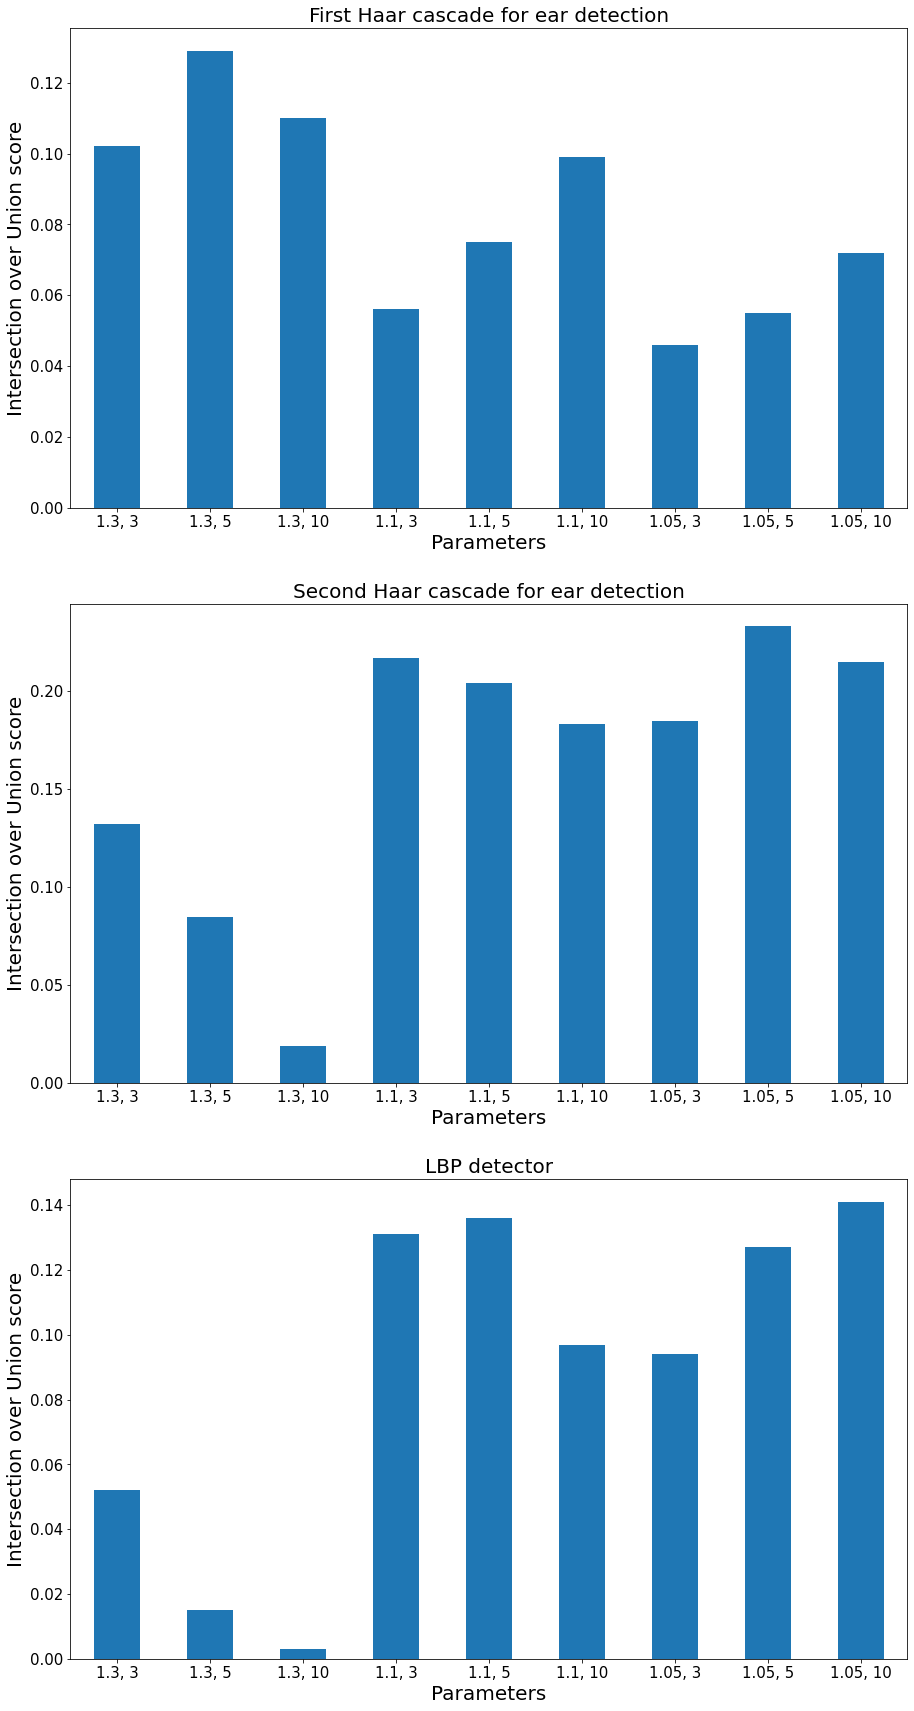

In [18]:
# Drawing a barplot to show the scores of different cascades
draw_barplot(iou_scores_df)
plt.savefig('plot_1.png')

## Checking how face detector performs as ear detector

In [19]:
iou_scores_df = pd.DataFrame()
for i in range(1):
    iou_scores = []
    
    for scale_factor in scale_factors:
        for min_neighbour in min_neighbours:
            min_neigh_scores = []
            
            for fname in fname_strings:
                # Face detection
                img = cv2.imread(test_folder_path + fname)
                img_annot = cv2.imread(test_annot_path + fname)
                img_annot = np.zeros(np.shape(img_annot))
                detectionList = detector(img, 'face')
                vizualization(img_annot, detectionList, results_face, fname)
                
                # Evaluation of detector
                tmp_annot_im = cv2.imread(test_annot_rect + fname)
                ind_for_white = tmp_annot_im >= 128
                tmp_annot_im[ind_for_white] = 255
                ind_for_black = tmp_annot_im < 128
                tmp_annot_im[ind_for_black] = 0
                tmp_results_im = cv2.imread(results_face + fname)
                intersection = np.logical_and(tmp_annot_im, tmp_results_im)
                union = np.logical_or(tmp_annot_im, tmp_results_im)
                tmp_score = np.sum(intersection) / np.sum(union)
                min_neigh_scores.append(tmp_score)
                
            iou_scores.append(np.round(np.average(min_neigh_scores), 3))
    
    # Creating a dataframe for the results
    iou_scores_df = pd.DataFrame(iou_scores, index=index, columns=['haarcascade_frontalface_default'])
    
iou_scores_df

haarcascade_frontalface_default
Scale factors Min. neighbours                                 
1.30          3                                          0.011
              5                                          0.010
              10                                         0.008
1.10          3                                          0.019
              5                                          0.016
              10                                         0.011
1.05          3                                          0.021
              5                                          0.018
              10                                         0.013

### Now we'll do face detection on the images from the folder 'test', but only with the combination of values for the parameters *minNeighbours* and *scaleFactor* which gave the best results. We do this in order to use these detected images in the next section for improvement of our ear detectors.

In [7]:
scale_factor = 1.05
min_neighbour = 3
for fname in fname_strings:
    # Face detection with the best-performing parameters
    img = cv2.imread(test_folder_path + fname)
    img_annot = cv2.imread(test_annot_path + fname)
    img_annot = np.zeros(np.shape(img_annot))
    detectionList = detector(img, 'face')
    vizualization(img_annot, detectionList, results_face, fname)

## Ear detection improved by already determined face region

In [14]:
scale_factors = [1.3, 1.1, 1.05]
min_neighbours = [3, 5, 10]

iou_scores_df = pd.DataFrame()
# 'For' loop for detection and evaluation
for cascadeEar in cascades:
    iou_scores = []
    
    for scale_factor in scale_factors:
        for min_neighbour in min_neighbours:
            min_neigh_scores = []
            
            for fname in fname_strings:
                # Ear detection
                img = cv2.imread(test_folder_path + fname)
                img_annot = cv2.imread(test_annot_path + fname)
                img_annot = np.zeros(img_annot.shape)
                detectionList = detector(img, 'ear')
                vizualization(img_annot, detectionList, results_ear, fname)
                
                # Ear vs. Face comparison
                # We check for regions of a picture that were detected as part of a ear, and not part of a face.
                # Those pixels were colored white, because of the ear detector, so now we turn them into black,
                # into background, because they were mistakenly identified as ear region.
                tmp_ear_img = cv2.imread(results_ear + fname)
                tmp_face_img = cv2.imread(results_face + fname)
                ind_for_white = tmp_ear_img == 255
                ind_for_black = tmp_face_img == 0
                intersection = np.logical_and(ind_for_white, ind_for_black)
                tmp_ear_img[intersection] = 0
                
                # Evaluation of newly produced images(with corrected ear regions)
                tmp_annot_im = cv2.imread(test_annot_rect + fname)
                ind_for_white = tmp_annot_im >= 128
                tmp_annot_im[ind_for_white] = 255
                ind_for_black = tmp_annot_im < 128
                tmp_annot_im[ind_for_black] = 0
                intersection = np.logical_and(tmp_annot_im, tmp_ear_img)
                union = np.logical_or(tmp_annot_im, tmp_ear_img)
                tmp_score = np.sum(intersection) / np.sum(union)
                min_neigh_scores.append(tmp_score)
                
            iou_scores.append(np.round(np.average(min_neigh_scores), 3))
    
    # Adding the results for a particular cascade to 'iou_scores_df'
    tmp_df = pd.DataFrame(iou_scores, index=index)
    iou_scores_df = pd.concat([iou_scores_df, tmp_df], axis=1)

iou_scores_df.columns = ['haar_cascade_ear_1', 'haar_cascade_ear_2', 'LBP']
iou_scores_df

haar_cascade_ear_1  haar_cascade_ear_2    LBP
Scale factors Min. neighbours                                               
1.30          3                             0.043               0.034  0.015
              5                             0.047               0.018  0.003
              10                            0.035               0.001  0.000
1.10          3                             0.032               0.063  0.049
              5                             0.035               0.062  0.042
              10                            0.041               0.050  0.021
1.05          3                             0.027               0.062  0.049
              5                             0.029               0.069  0.053
              10                            0.035               0.057  0.042

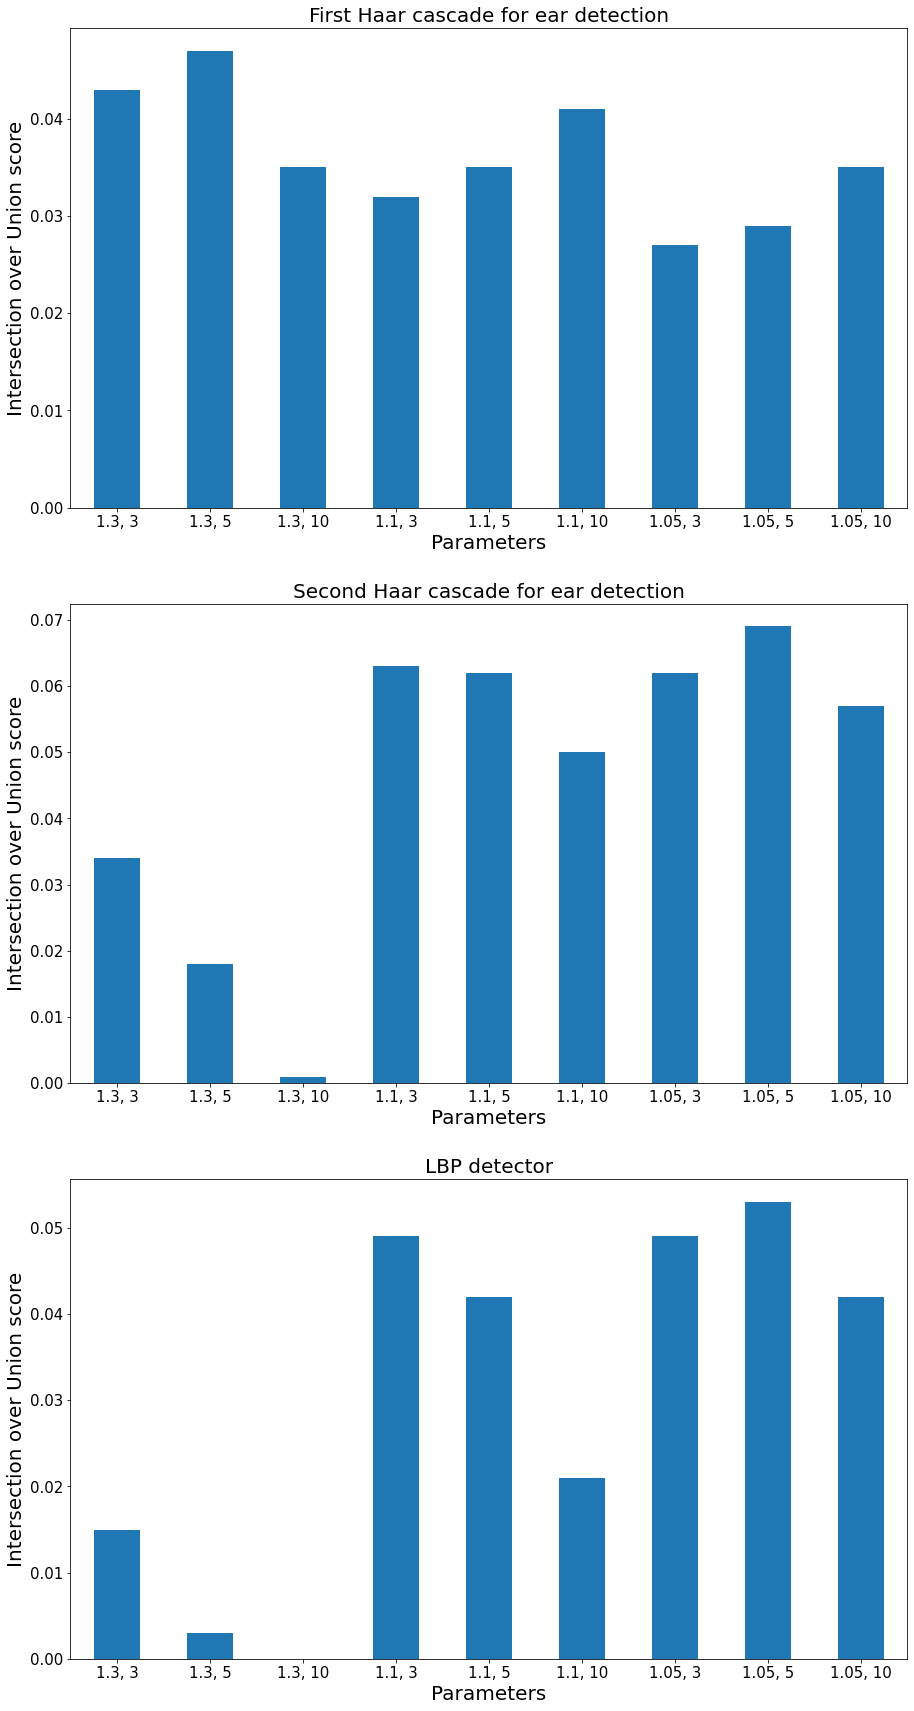

In [16]:
# Drawing a barplot to show the scores of different cascades
draw_barplot(iou_scores_df)
plt.savefig('plot_2.png')